# Group Classifier Validation

Load a trained group classifier model and generate validation plots:
- Load model from checkpoint
- Load validation data from parquet shards
- Generate predictions
- Create evaluation plots (confusion matrices, ROC curves, precision-recall, loss curves)


In [1]:
import torch
import numpy as np
from pathlib import Path
from datetime import datetime

from pioneerml.common.zenml import load_step_output
from pioneerml.common.zenml import utils as zenml_utils
from pioneerml.common.loader import GroupClassifierGraphLoader
from pioneerml.common.evaluation.plots import (
    plot_multilabel_confusion_matrix,
    plot_roc_curves,
    plot_precision_recall_curves,
    plot_embedding_space,
    plot_probability_distributions,
    plot_confidence_analysis,
)
from pioneerml.pipelines.inference.group_classification import group_classification_inference_pipeline

PROJECT_ROOT = zenml_utils.find_project_root()
zenml_utils.setup_zenml_for_notebook(root_path=PROJECT_ROOT, use_in_memory=True)

print(f"Project root: {PROJECT_ROOT}")


Using ZenML repository root: /workspace
Ensure this is the top-level of your repo (.zen must live here).
Project root: /workspace


## List Available Checkpoints

Find all saved model checkpoints and their metadata files.


In [2]:
# List and print all available torchscript exports
model_dir = Path(PROJECT_ROOT) / "trained_models" / "groupclassifier"
checkpoints = sorted(model_dir.glob("*_torchscript.pt"), key=lambda p: p.stat().st_mtime, reverse=True)
if not checkpoints:
    raise ValueError(f"No torchscript models found in {model_dir}")

print(f"Found {len(checkpoints)} model export(s).")
for i, p in enumerate(checkpoints[:10]):
    print(f"[{i}] {p.name}")

print(f"Using latest model: {checkpoints[0].name}")


Found 62 model export(s).
[0] groupclassifier_20260213_222349_torchscript.pt
[1] groupclassifier_20260213_220046_torchscript.pt
[2] groupclassifier_20260211_143738_torchscript.pt
[3] groupclassifier_20260211_141712_torchscript.pt
[4] groupclassifier_20260211_140843_torchscript.pt
[5] groupclassifier_20260210_221756_torchscript.pt
[6] groupclassifier_20260208_223249_torchscript.pt
[7] groupclassifier_20260208_222641_torchscript.pt
[8] groupclassifier_20260208_221743_torchscript.pt
[9] groupclassifier_20260208_221206_torchscript.pt
Using latest model: groupclassifier_20260213_222349_torchscript.pt


## Load Model

Reconstruct the model architecture from metadata and load the saved weights.


In [3]:
# Select model path (latest by default)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = str(checkpoints[0].resolve())

print(f"Model path: {model_path}")
print(f"Device: {device}")


Model path: /workspace/trained_models/groupclassifier/groupclassifier_20260213_222349_torchscript.pt
Device: cuda


## Load Validation Data

Load the same data pattern used during training (or a subset for faster validation).


In [4]:
# Load validation parquet inputs
parquet_dir = Path(PROJECT_ROOT) / "data"
parquet_paths = sorted(parquet_dir.glob("ml_output_*.parquet"))

# Example: uncomment to select a smaller subset
# parquet_paths = parquet_paths[:1]

parquet_paths = [str(p.resolve()) for p in parquet_paths]
if not parquet_paths:
    raise ValueError(f"No parquet files found in {parquet_dir}")

print(f"Validation files: {len(parquet_paths)}")
for p in parquet_paths:
    print(" -", p)


Validation files: 5
 - /workspace/data/ml_output_000.parquet /workspace/data/ml_output_000.parquet
 - /workspace/data/ml_output_001.parquet /workspace/data/ml_output_001.parquet
 - /workspace/data/ml_output_002.parquet /workspace/data/ml_output_002.parquet
 - /workspace/data/ml_output_003.parquet /workspace/data/ml_output_003.parquet
 - /workspace/data/ml_output_004.parquet /workspace/data/ml_output_004.parquet


## Generate Predictions

Run inference on the validation dataset.


In [5]:
# Run inference pipeline in validation mode (loader.mode='train' includes truth targets)
run = group_classification_inference_pipeline.with_options(enable_cache=False)(
    parquet_paths=parquet_paths,
    model_path=model_path,
    output_dir=str((Path(PROJECT_ROOT) / "data" / "group_classifier").resolve()),
    pipeline_config={
        "loader": {
            "config_json": {
                "mode": "train",
                "batch_size": 64,
                "chunk_row_groups": 4,
                "chunk_workers": 0,
            }
        },
        "inference": {"threshold": 0.5},
        "export": {"check_accuracy": True, "write_timestamped": False},
    },
)

inference_outputs = load_step_output(run, "run_group_classifier_inference")
export_info = load_step_output(run, "export_group_classifier_predictions")

predictions = inference_outputs["probs"].to(torch.float32)
targets = inference_outputs["targets"].to(torch.float32)

print("Generated predictions:")
print(f"  Predictions shape: {tuple(predictions.shape)}")
print(f"  Targets shape: {tuple(targets.shape)}")
print(f"  Predictions range: [{predictions.min():.4f}, {predictions.max():.4f}]")
print("export:", export_info)


Initiating a new run for the pipeline: group_classification_inference_pipeline.
Caching is disabled by default for group_classification_inference_pipeline.
Using user: default
Using stack: default
  deployer: default
  artifact_store: default
  orchestrator: default
You can visualize your pipeline runs in the ZenML Dashboard. In order to try it locally, please run zenml login --local.
Step load_group_classifier_inference_inputs has started.
Step load_group_classifier_inference_inputs has finished in 0.170s.
Step load_group_classifier_model has started.
Step load_group_classifier_model has finished in 0.095s.
Step run_group_classifier_inference has started.
Step run_group_classifier_inference has finished in 5.262s.
Step export_group_classifier_predictions has started.
Step export_group_classifier_predictions has finished in 0.441s.
Pipeline run has finished in 8.426s.
Generated predictions:
  Predictions shape: (18638, 3)
  Targets shape: (18638, 3)
  Predictions range: [0.0000, 1.0000

## Generate Validation Plots

Create comprehensive evaluation plots to assess model performance.


In [6]:
# Create output directory for plots
plots_dir = Path(PROJECT_ROOT) / "artifacts" / "validation_plots" / "group_classifier"
plots_dir.mkdir(parents=True, exist_ok=True)

timestamp_str = datetime.now().strftime("%Y%m%d_%H%M%S")
plot_prefix = f"group_classifier_{timestamp_str}"

class_names = ["pion", "muon", "mip"]

print(f"Generating validation plots in: {plots_dir}")
print(f"Class names: {class_names}")


Generating validation plots in: /workspace/artifacts/validation_plots/group_classifier
Class names: ['pion', 'muon', 'mip']


### Confusion Matrix

The confusion matrix shows how well the model classifies each particle type. It displays the true labels vs predicted labels in a grid format.

**How to interpret:**
- **Diagonal elements** (top-left to bottom-right): Correct predictions. Higher values indicate better performance for that class.
- **Off-diagonal elements**: Misclassifications. Shows which classes are being confused with each other.
- **Normalized values**: Percentages show the proportion of each true class that was predicted as each class. A perfect classifier would have 100% on the diagonal and 0% elsewhere.
- **Class imbalance**: If one class has many more samples, it may appear to perform better simply due to volume. Check the normalized matrix to see true performance.

**What to look for:**
- High diagonal values indicate good classification
- Off-diagonal patterns reveal systematic confusions


1. Generating confusion matrices...


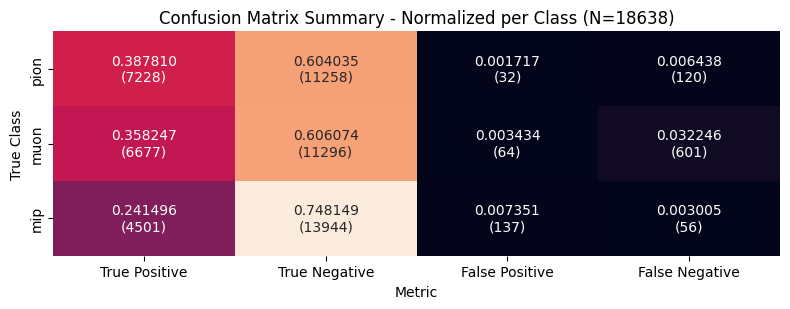

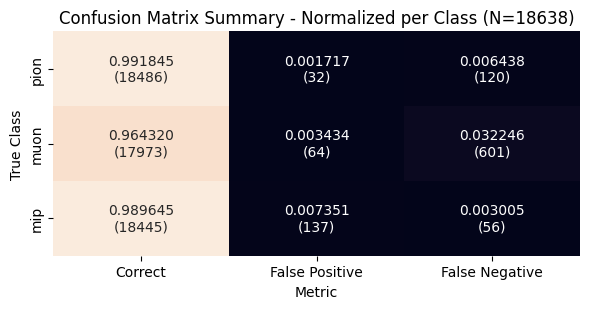

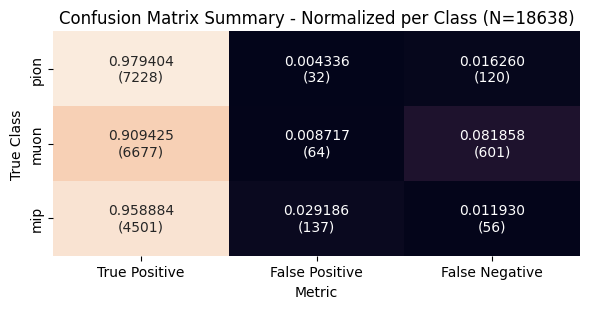

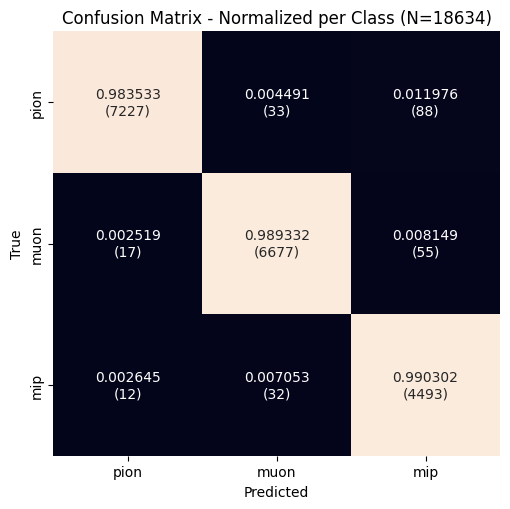

'/workspace/artifacts/validation_plots/group_classifier/group_classifier_20260213_230420_confusion_matrix_class_normalized.png'

In [8]:
# 1. Confusion Matrix

print("1. Generating confusion matrices...")

plot_multilabel_confusion_matrix(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    precision=6,
    view_mode="summary",
    summary_mode="default",
    threshold=0.5,
    normalize=True,
    save_path=plots_dir / f"{plot_prefix}_confusion_matrix_summary.png",
    show=True,
)

plot_multilabel_confusion_matrix(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    precision=6,
    view_mode="summary",
    summary_mode="correct_mode",
    threshold=0.5,
    normalize=True,
    save_path=plots_dir / f"{plot_prefix}_confusion_matrix_summary_correct.png",
    show=True,
)

plot_multilabel_confusion_matrix(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    precision=6,
    view_mode="summary",
    summary_mode="true_positive_mode",
    threshold=0.5,
    normalize=True,
    save_path=plots_dir / f"{plot_prefix}_confusion_matrix_summary_true_positives.png",
    show=True,
)

plot_multilabel_confusion_matrix(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    precision=6,
    view_mode="nxn",
    normalize_mode="row",
    threshold=0.5,
    save_path=plots_dir / f"{plot_prefix}_confusion_matrix_class_normalized.png",
    show=True,
)


### ROC Curves (Receiver Operating Characteristic)

ROC curves show the trade-off between the true positive rate (sensitivity) and false positive rate (1 - specificity) at different classification thresholds.

**How to interpret:**
- **X-axis (False Positive Rate)**: Proportion of negative samples incorrectly classified as positive. Lower is better.
- **Y-axis (True Positive Rate / Recall)**: Proportion of positive samples correctly identified. Higher is better.
- **Diagonal line (AUC = 0.5)**: Random guessing baseline. Any curve above this indicates the model is learning.
- **AUC (Area Under Curve)**: 
  - AUC = 1.0: Perfect classifier

**What to look for:**
- Curves that hug the top-left corner indicate better performance
- Higher AUC values mean the model can better distinguish between classes
- Compare curves across classes to identify which particle types are easier/harder to classify
- ROC curves are useful when classes are relatively balanced (i.e. ~equally likely to see each class from a random sample)


2. Generating ROC curves...


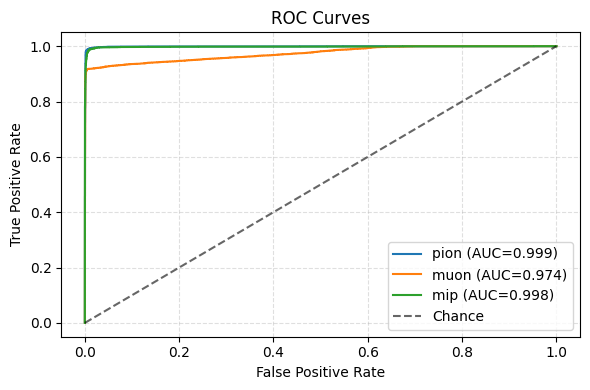

'/workspace/artifacts/validation_plots/group_classifier/group_classifier_20260213_230420_roc_curves.png'

In [10]:
# 2. ROC Curves
print("2. Generating ROC curves...")
plot_roc_curves(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    save_path=plots_dir / f"{plot_prefix}_roc_curves.png",
    show=True,
)


### Precision-Recall Curves

Precision-Recall curves show the relationship between precision (accuracy of positive predictions) and recall (coverage of positive samples) at different thresholds.

**How to interpret:**
- **X-axis (Recall)**: Proportion of actual positives that were correctly identified. Also called sensitivity or true positive rate.
- **Y-axis (Precision)**: Proportion of predicted positives that are actually positive. Measures prediction quality.
- **AP (Average Precision)**: The area under the PR curve. It's computed by ranking predictions and averaging precision at each recall level, which is mathematically equivalent to integrating the PR curve. Higher values indicate better performance.

**What to look for:**
- Curves that stay high on the Y-axis (high precision) indicate confident, accurate predictions
- Curves that extend far right (high recall) mean the model finds most positive samples
- **Precision-Recall vs ROC**: PR curves are more informative than ROC when classes are imbalanced, as they focus on the positive class performance


3. Generating precision-recall curves...


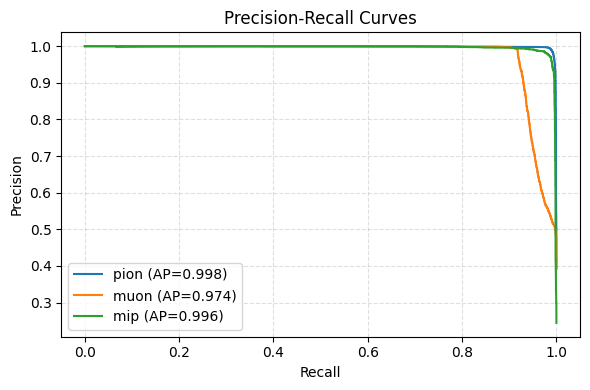

'/workspace/artifacts/validation_plots/group_classifier/group_classifier_20260213_230420_precision_recall.png'

In [12]:
# 3. Precision-Recall Curves
print("3. Generating precision-recall curves...")
plot_precision_recall_curves(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    save_path=plots_dir / f"{plot_prefix}_precision_recall.png",
    show=True,
)


In [13]:
# TorchScript export only exposes forward(), not extract_embeddings().
# Use prediction/logit space as embedding proxy for projection diagnostics.
embeddings = predictions.detach().cpu()
targets_for_emb = targets.detach().cpu()

print("Embedding proxy:")
print(f"  Embeddings shape: {tuple(embeddings.shape)}")
print(f"  Targets shape: {tuple(targets_for_emb.shape)}")


Embedding proxy:
  Embeddings shape: (18638, 3)
  Targets shape: (18638, 3)


### Probability Distributions

Show how well separated the probability distributions are for each class. These plots display the predicted probabilities (after softmax) for each particle type.

**How to interpret:**
- **Probability values**: After applying softmax, predictions are converted to probabilities (0-1).
- **Histogram shape**: 
  - Sharp peak near 1.0 for correct class = confident, accurate predictions
  - Broad distribution = uncertain predictions
  - Peak near 0.0 for incorrect classes = good discrimination

**What to look for:**
- Strong peaks at high probability for the correct class indicate confident, accurate predictions
- Low probabilities for incorrect classes show good discrimination


Generating probability and confidence plots...


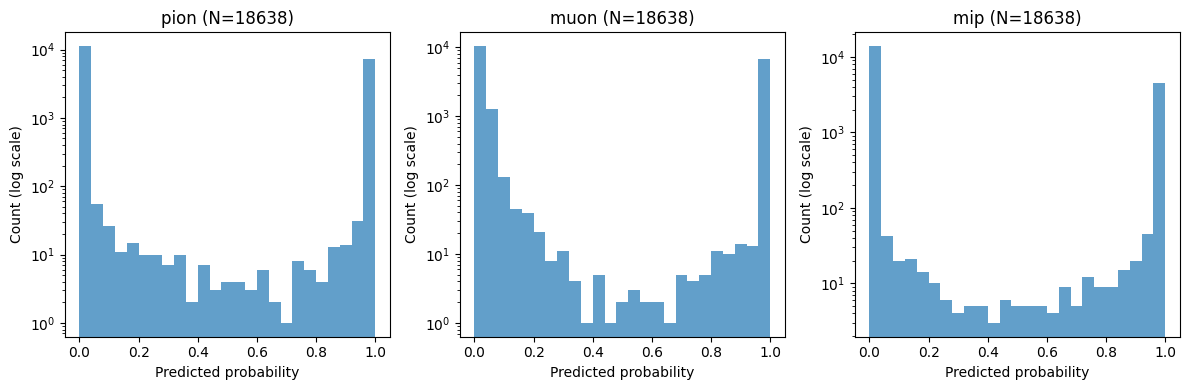

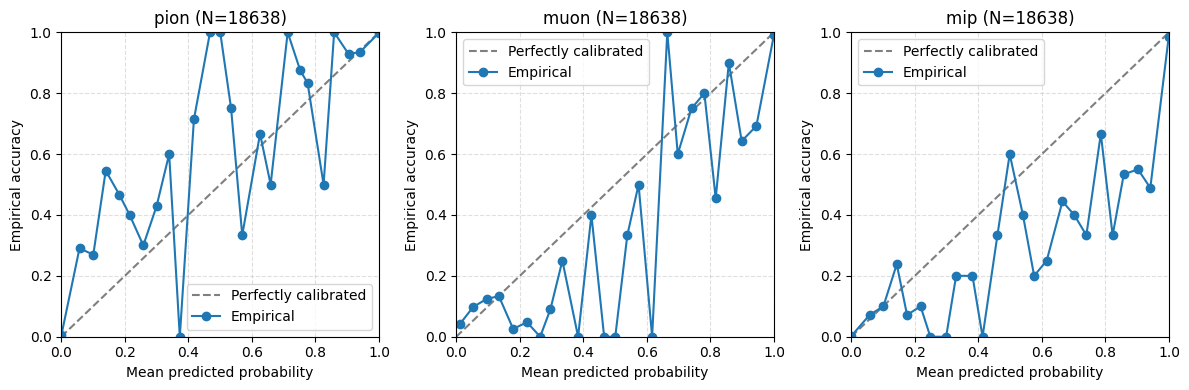

'/workspace/artifacts/validation_plots/group_classifier/group_classifier_20260213_230420_confidence_analysis.png'

In [15]:
print("Generating probability and confidence plots...")
plot_probability_distributions(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    save_path=plots_dir / f"{plot_prefix}_probability_distributions.png",
    show=True,
)
plot_confidence_analysis(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    save_path=plots_dir / f"{plot_prefix}_confidence_analysis.png",
    show=True,
)


### Input Space Visualization (t-SNE, PCA, UMAP)

Before examining how the model transforms data internally, it is equally important to understand the **structure of the raw input space** itself.  
By projecting the original input features (e.g., averaged node features from each graph) into 2D, we gain insight into what structure is already present *before* the model applies any learned transformations.

This serves as a baseline:  
- If structure already exists in the raw data, the model may only need to refine or cleanly separate it.  
- If no structure exists, the model must create a new representation to make the classes separable.  
- If the model produces structure that does *not* exist in the input, this may indicate overfitting or meaningful feature extraction, depending on consistency across projections.

We use three complementary dimensionality-reduction methods for the input space:

- **t-SNE**: Reveals nonlinear local structure and fine-grained cluster tendencies.
- **PCA**: Shows global, linear variance structure of the input.
- **UMAP**: Highlights manifold geometry and can expose subtle modes even when PCA cannot.

---

### **How to interpret input-space projections**

- **Clusters in input space**  
  Suggests that the raw features already contain discriminative information. The model’s task is easier; it will likely amplify these effects.
  
- **Overlap between classes in input space**  
  Indicates that raw features alone are not sufficient for clean separation. The model must learn nonlinear transformations to distinguish classes.

- **Multiple subclusters inside a single class**  
  Points to **true multimodal structure**. This means you can expect subclusters to form in the embedding space as well. If the raw input space doesn not contain class subclusters but the embedded space does this can be evidence of overtraining.

- **PCA shows one cluster per class but t-SNE/UMAP show subclusters**  
  Means the input space contains *nonlinear* structure not visible to linear projections. Be wary though, t-SNE is prone to creating subclusters that aren't present in the higher dimensional space. This effect can be mitigated by raising the perplexity.

---

### **Method-specific insights for the input space**

#### **PCA (Input Space)**
- If PCA shows large-scale separation between classes, the data is linearly separable.
- If PCA shows a single dense region per class, but t-SNE/UMAP reveal subclusters, the structure is nonlinear.

#### **t-SNE (Input Space)**
- Highlights local neighborhoods and small-scale patterns.
- If t-SNE already splits a class into multiple islands, **the multimodality exists in the raw data**, not just in the model. Again, be wary of artifacts of the t-SNE algorithm.

#### **UMAP (Input Space)**
- Gives a topology-aware view of the raw feature manifold.
- Subclusters appearing in UMAP are usually **real** (not artifacts), especially if they persist across seeds. UMAP tends to not create subcluster artifacts as often as t-SNE; it preserves global clusters better than t-SNE. In general, UMAP is better than t-SNE for our purposes, but it's a much more expensive algorithm. Really it should only be used in a "tiebreaker" scenario; i.e. PCA and t-SNE are telling two different stories.

---

### **How to compare input space vs. embedding space**

The key diagnostic is **consistency**:

| Observation | Interpretation |
|------------|----------------|
| **Input PCA: one blob**<br>**Input t-SNE/UMAP: multiple clusters** | Raw data is nonlinear and multimodal; PCA hides it. |
| **Model embedding shows the same subclusters** | The model is uncovering and *stabilizing* real structure. Not overfitting. |
| **Model embedding shows *more* subclusters than input** | Model may be amplifying subtle distinctions → could be meaningful or representational fragmentation. Compare with PCA/UMAP. |
| **Model embedding merges input subclusters** | Model is learning an invariant representation that smooths irrelevant variation. |
| **Model embedding shows structure not present in any input projection** | Possible overfitting or memorization; investigate cluster stability. |

---

In short:

> **Input-space projections show you the geometry the model starts with.  
Embedding-space projections show you what structure the model chooses to represent.  
Comparing the two reveals whether the model is overtraining or not.**


Collected 8000 input samples for projections (feat dim=4).


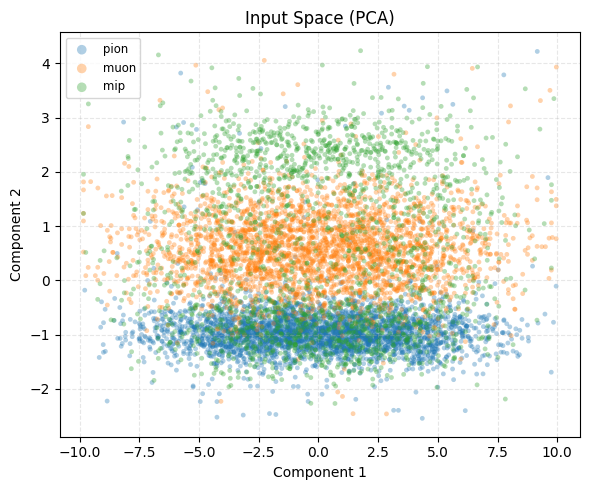

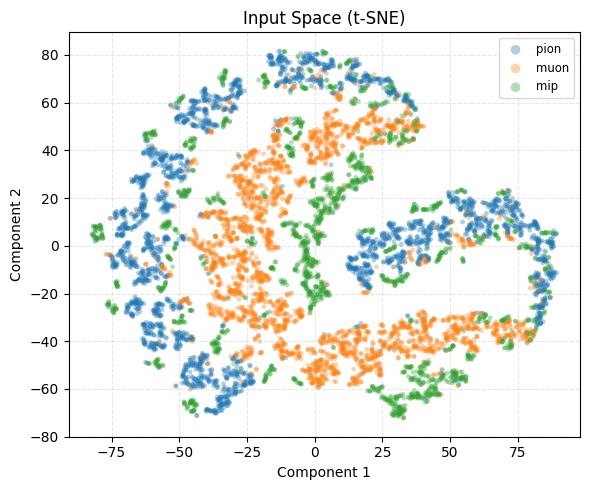

In [16]:
# Input-space projections (raw node features)
max_input_samples = 8000
input_feats = []
input_targets = []

loader = GroupClassifierGraphLoader(
    parquet_paths=parquet_paths,
    mode="train",
    batch_size=256,
    row_groups_per_chunk=4,
    num_workers=0,
)

for batch in loader.make_dataloader(shuffle_batches=False):
    x = batch.x.cpu()
    y = batch.y.cpu()
    b = batch.batch.cpu()
    num_graphs = int(batch.num_graphs)
    for gid in range(num_graphs):
        idx = torch.nonzero(b == gid, as_tuple=False).view(-1)
        if idx.numel() == 0:
            continue
        input_feats.append(x[idx].mean(dim=0).numpy())
        input_targets.append(y[gid].numpy())
        if len(input_feats) >= max_input_samples:
            break
    if len(input_feats) >= max_input_samples:
        break

input_feats = np.asarray(input_feats, dtype=np.float32)
input_targets = np.asarray(input_targets, dtype=np.float32)

print(f"Collected {len(input_feats)} input samples for projections (feat dim={input_feats.shape[1] if input_feats.size else 0}).")

if len(input_feats) > 2:
    plot_embedding_space(
        embeddings=input_feats,
        targets=input_targets,
        class_names=class_names,
        method="pca",
        title="Input Space (PCA)",
        random_state=42,
        max_samples=max_input_samples,
        save_path=plots_dir / f"{plot_prefix}_input_space_pca.png",
        show=True,
        verbose=True,
    )

    plot_embedding_space(
        embeddings=input_feats,
        targets=input_targets,
        class_names=class_names,
        method="tsne",
        title="Input Space (t-SNE)",
        random_state=42,
        max_samples=max_input_samples,
        save_path=plots_dir / f"{plot_prefix}_input_space_tsne.png",
        show=True,
        verbose=True,
    )


### Embedding Space Visualization (t-SNE, PCA, UMAP)

After looking at the raw input space, we also want to understand how the **model internally reorganizes the data**.  
By projecting the learned **embedding vectors** (the activations from an intermediate layer) into 2D, we get a direct view of the structure the model constructs to separate particle classes.

These projections help identify whether the network is:

- clarifying existing structure,
- amplifying meaningful differences,
- or inventing distinctions that do not appear in the input space.

We use the same three dimensionality-reduction tools:

- **t-SNE** — emphasizes local neighborhoods; good for spotting cluster boundaries.  
  https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding  
- **PCA** — linear projection; shows the large-scale geometric structure.  
  https://en.wikipedia.org/wiki/Principal_component_analysis  
- **UMAP** — manifold-based method; preserves both local and moderate global structure.  
  https://en.wikipedia.org/wiki/UMAP  

---

### **How to interpret embedding-space projections**

- **Clear class clusters**  
  Indicates that the model has successfully learned separable representations.

- **Class overlap**  
  Means the embedding layer has not cleanly separated those particle types.

- **Tight, compact clusters**  
  Suggest stable, low-variance representations.

- **Diffuse or elongated clusters**  
  Suggest variability within the class or insufficient feature extraction.

- **Multiple subclusters within a class**  
  - real multimodal structure in the data (common in physics),  
  - or representational fragmentation (possible overfitting),  
  - or t-SNE artifacts — use PCA/UMAP as checks.

---

### **Method-specific notes**

#### **t-SNE (Embedding Space)**
Useful for exposing fine structure, but sensitive to perplexity and randomness.  
Fragmentation seen only in t-SNE should be treated cautiously.

#### **PCA (Embedding Space)**
Provides a stable global view.  
If PCA shows multiple well-separated islands, those islands are *real* in the embedding space and not just t-SNE artifacts.

#### **UMAP (Embedding Space)**
More topology-preserving than t-SNE.  
If both PCA and UMAP agree on subclusters, those structures are reliably present in the learned representation.
UMAP is better for our purposes than t-SNE because it is less prone to artificially splitting clusters. The only downside is it is much more computationally expensive to run. As a result, I prefer to use it as a "tiebreaker" if t-SNE and PCA disagree.

---

### **What to look for across methods**

- **Consistent clusters across PCA, t-SNE, and UMAP** → strong, stable embeddings.
- **Fragmentation only in t-SNE** → likely an artifact.
- **Multiple subclusters across all methods** → model is reflecting true multimodality in the data.
- **Large overlap across all methods** → embeddings are not discriminative enough.

---

In short:

> **Input-space projections tell you what structure exists in the raw data.  
Embedding-space projections tell you how the model transforms that structure.  
Comparing the two is the main way to detect whether the model is representing real structure or overtraining.**


[embedding] Subsampled to 8000 samples for speed.
[embedding] Pre-reduced to 3 dims via PCA.


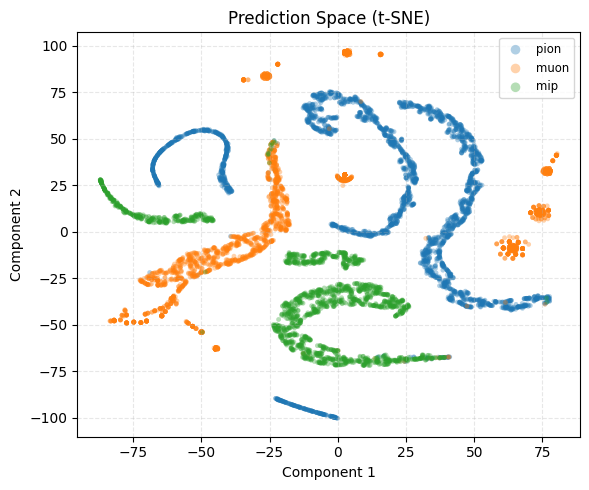

[embedding] Subsampled to 8000 samples for speed.


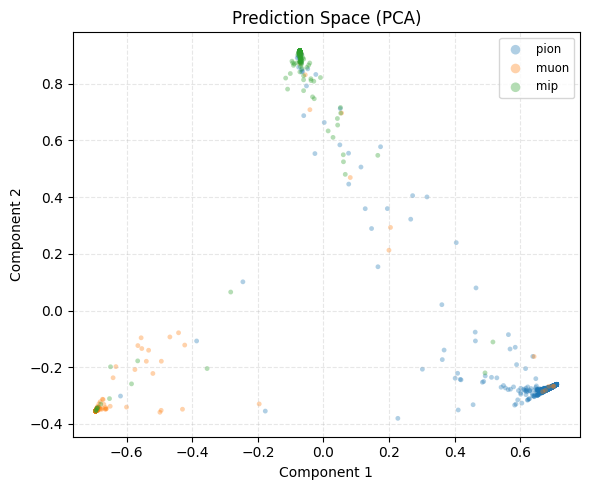

'/workspace/artifacts/validation_plots/group_classifier/group_classifier_20260213_230420_prediction_space_pca.png'

In [17]:
# t-SNE
plot_embedding_space(
    embeddings=embeddings,
    targets=targets_for_emb,
    class_names=class_names,
    method="tsne",
    title="Prediction Space (t-SNE)",
    perplexity=30.0,
    n_components=2,
    random_state=42,
    show=True,
    max_samples=8000,
    pre_pca_components=50,
    save_path=plots_dir / f"{plot_prefix}_prediction_space_tsne.png",
    verbose=True,
)

# PCA
plot_embedding_space(
    embeddings=embeddings,
    targets=targets_for_emb,
    class_names=class_names,
    method="pca",
    title="Prediction Space (PCA)",
    n_components=2,
    random_state=42,
    show=True,
    max_samples=8000,
    pre_pca_components=50,
    save_path=plots_dir / f"{plot_prefix}_prediction_space_pca.png",
    verbose=True,
)


In [18]:
print(f"Saved validation plots to: {plots_dir}")


Saved validation plots to: /workspace/artifacts/validation_plots/group_classifier
